In [260]:
# !pip install kaleido numpy pandas neurokit2 plotly pyplr seaborn ts2vg

### Imports and helper functios

In [261]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import plotly.express as px
from _plotly_utils.colors import n_colors
from matplotlib import pyplot as plt
import plotly.graph_objs as go
from pyplr import preproc
import warnings
import glob
from operator import itemgetter
import os

from util import plot_data, plot_channels, plot_gantt, markers_to_gantt, plot_epoch, plot_correlation_matrix, seconds_to_samples, samples_to_seconds
from IPython.display import display

In [262]:
# Adapted from Neurokit's read_xdf() to work with the data from this experiment
# https://neuropsychology.github.io/NeuroKit/functions/data.html#neurokit2.data.read_xdf
def read_xdf(filename, upsample=2, fillmissing=None):
    """**Read and tidy an XDF file**"""

    def get_markers(markers_stream):
        markers = markers_stream['time_series']
        assert all(len(marker) == 1 for marker in markers), 'Warning: There is an event containing more than one marker'
        markers = [marker[0] for marker in markers]

        # Only keep unique markers occurring in expected order
        relevant_indices = []
        expected_marker_order = ['app-start', 'cookies-start', 'cookies-end', 'geolocation-start', 'geolocation-end', 'confirmshaming-start', 'confirmshaming-end', 'personalDetails-start', 'confusingCheckbox-start', 'confusingCheckbox-end', 'personalDetails-end', "creditCard-start", "creditCard-end", 'id-start', "cameraPermission-start", "cameraPermission-end", 'id-end', 'app-end']
        previous_index = 0
        for marker in expected_marker_order:
            if marker in markers[previous_index:]:
                index = markers.index(marker, previous_index)
                relevant_indices.append(index)
                previous_index = index
            else:
                print(f'Missing marker: {marker}')

        timestamps = itemgetter(*relevant_indices)(markers_stream['time_stamps'])
        markers = itemgetter(*relevant_indices)(markers)
        return markers, timestamps

    try:
        import pyxdf
    except ImportError:
        raise ImportError(
            "The 'pyxdf' module is required for this function to run. ",
            "Please install it first (`pip install pyxdf`).",
        )

    # Load file
    print(f"Reading file: {filename}")
    streams, header = pyxdf.load_xdf(filename)

    # Remove any empty streams
    streams = [stream for stream in streams if len(stream['time_series'])]

    # Process markers stream first
    markers_stream = next(filter(lambda stream: isinstance(stream['time_series'], list), streams))
    streams.remove(markers_stream)
    markers, timestamps = get_markers(markers_stream)

    # Get the smallest time stamp ('app-start') to later use as offset (zero point) as well as the largest timestamp ('app-end') to cut off data
    offset = min(timestamps)
    max_ts = max(timestamps) - offset

    markers_df = pd.DataFrame(markers, columns=['marker'])
    markers_df.index = pd.to_datetime(timestamps - offset, unit="s")

    # Process other streams and convert to dataframes
    dfs = []
    for stream in streams:
        channels_info = stream["info"]["desc"][0]["channels"][0]["channel"]
        cols = [channels_info[i]["label"][0] for i in range(len(channels_info))]
        dat = pd.DataFrame(stream["time_series"], columns=cols)

        # Get time stamps and offset from minimum time stamp
        dat.index = pd.to_datetime(stream["time_stamps"] - offset, unit="s")
        dfs.append(dat)

    # Store info of each stream ----------------------------------------------------------------
    # Store metadata
    info = {
        "sampling_rates_original": [float(s["info"]["nominal_srate"][0]) for s in streams],
        "sampling_rates_effective": [float(s["info"]["effective_srate"]) for s in streams],
        "datetime": header["info"]["datetime"][0],
        "data": dfs,
    }

    # Synchronize ------------------------------------------------------------------------------
    # Merge all dataframes by timestamps
    # Note: this is a critical steps, as it inserts timestamps and makes it non-evenly spread
    streams_df = dfs[0]
    for i in range(1, len(dfs)):
        streams_df = pd.merge(streams_df, dfs[i], how="outer", left_index=True, right_index=True)
    streams_df = streams_df.sort_index()

    # Resample and Interpolate -----------------------------------------------------------------
    # Final sampling rate will be 2 times the maximum sampling rate
    # (to minimize aliasing during interpolation)
    info["sampling_rate"] = int(np.max(info["sampling_rates_original"]) * upsample)

    if fillmissing is not None:
        fillmissing = int(info["sampling_rate"] * fillmissing)

    # Create new index with evenly spaced timestamps
    idx = pd.date_range(streams_df.index.min().floor(freq='s'), streams_df.index.max(), freq=str(1000 / info["sampling_rate"]) + "ms")
    streams_df = streams_df.reindex(streams_df.index.union(idx))

    # Interpolate numeric columns across the new index
    streams_df = streams_df.interpolate(method="index", limit=fillmissing)

    # Drop the old timestamp indices
    streams_df = streams_df.reindex(idx)

    # Cut off data before first marker and after last marker
    streams_df = streams_df[(streams_df.index >= pd.to_datetime(0)) & (streams_df.index <= pd.to_datetime(max_ts, unit='s'))]

    return streams_df, markers_df, info

In [263]:
def get_signals_and_events(streams_df, markers_df, info, plot=True):
    # Clean up the streams
    
    # Rename some columns for clarity
    rename_columns = {
        # 'RAW0': 'PPG',
        'EDABITREV1': 'EDA', 'ECGBIT2': 'ECG'}

    pupil_cols = ['left_pupil_diameter', 'right_pupil_diameter']
    pupil_validity_cols = ['left_pupil_validity', 'right_pupil_validity']
    # Keep only the columns we want
    columns_to_keep = [*rename_columns.values(),
                       *pupil_validity_cols,
                       *pupil_cols,
                       ]

    streams_df = streams_df.rename(columns=rename_columns)
    streams_df = streams_df[columns_to_keep]

    if plot:
        # Plot raw data except the left_pupil_validity and right_pupil_validity columns
        plot_data(streams_df.drop(columns=pupil_validity_cols), markers_df, title='Raw Channel Data', hide_end_markers=True)
    
    def pupil_process():
        # Process pupil diameter
        pupil_signal = preproc.mask_pupil_first_derivative(streams_df, threshold=2.0, mask_cols=pupil_cols)
    
        # Mask pupil confidence threshold
        for pupil, pupil_validity in zip(pupil_cols, pupil_validity_cols):
            pupil_signal[pupil] = pupil_signal[pupil].mask(pupil_signal[pupil_validity] < 0.99)
    
        # Interpolate pupil samples
        pupil_signal = preproc.interpolate_pupil(pupil_signal, interp_cols=pupil_cols)
    
        # Smooth pupil data with Butterworth filter
        pupil_signal = preproc.butterworth_series(pupil_signal, fields=pupil_cols, filt_order=3, cutoff_freq=4/(info["sampling_rate"]/2))
    
        pupil_signal['pupil_diameter'] = pupil_signal[pupil_cols].mean(axis=1)
    
        pupil_signal = pupil_signal.reset_index(drop=True)
        return pupil_signal
    
    # Process pupil diameter
    pupil_signal = pupil_process()

    # Process EDA
    eda_signals, eda_info = nk.eda_process(streams_df['EDA'], sampling_rate=info["sampling_rate"], method_cleaning="biosppy")
    if plot:
        nk.eda_plot(eda_signals, eda_info)

    # Process ECG
    ecg_signals, ecg_info = nk.ecg_process(streams_df['ECG'], sampling_rate=info["sampling_rate"], method="vg")
    if plot:
        nk.ecg_plot(ecg_signals, ecg_info)
        
    # Process HRV with a sliding window
    hrv = pd.Series(index=ecg_signals.index, dtype=float)
    window_size = seconds_to_samples(1.5, info["sampling_rate"])
    overlap = seconds_to_samples(0.75, info["sampling_rate"])
    peaks, _ = nk.ecg_peaks(ecg_signals['ECG_Clean'], sampling_rate=info["sampling_rate"])
    for i in range(0, len(peaks) - window_size, overlap):
        samples = peaks[i:i + window_size]
        if sum(samples['ECG_R_Peaks']) < 2:
            # not enough R-peaks in the window
            continue
        hrv_params = nk.hrv_time(samples, sampling_rate=info["sampling_rate"])
        hrv_mean = hrv_params['HRV_RMSSD']
        hrv.at[i + window_size] = hrv_mean
    # Add the HRV parameter as a column to ECG 
    ecg_signals['HRV_RMSSD'] = hrv
    ecg_signals['HRV_RMSSD'] = ecg_signals['HRV_RMSSD'].interpolate(method='linear')

    # Concatenate processed signals
    signals = pd.concat([ecg_signals, eda_signals, pupil_signal], axis=1)

    # Reindex markers with numeric index for further processing
    markers_numindexed = markers_df.set_index(streams_df.index.get_indexer(markers_df.index, method='nearest'))
    # Remove the first and last marker and camera permission markers
    markers_to_remove = ['app-start', 'app-end', 
                         'cameraPermission-start', 'cameraPermission-end'
                         ]
    markers_df = markers_df[~markers_df.marker.isin(markers_to_remove)]
    markers_numindexed = markers_numindexed[~markers_numindexed.marker.isin(markers_to_remove)]
    
    if plot:
        # Plot processed signals (only some columns)
        columns_to_plot = ['EDA_Tonic', 'EDA_Phasic', 'ECG_Clean', 'ECG_Rate', 'pupil_diameter']
        plot_channels(signals[columns_to_plot], markers_numindexed, title='Processed Channel Data', hide_end_markers=True)
        plot_gantt(markers_df)

    # Create events dictionary from gantt data for event-related analysis
    gantt_data = markers_to_gantt(markers_numindexed)
    
    labels = [d['marker'] for d in gantt_data]
    events = dict(
        onset=[d['start'] for d in gantt_data],
        duration=[d['end'] - d['start'] for d in gantt_data],
        label=labels,
        condition=labels
    )

    return signals, events

In [264]:
def get_epoch_features(signals, events, plot=True):
    # Build epochs from events
    epochs = nk.epochs_create(signals, events, sampling_rate=info["sampling_rate"], epochs_start=-1, epochs_end=5)

    # Create a non-epoch signals dataframe
    epoch_onsets = events['onset']
    epoch_lengths = [len(e) for e in epochs.values()]
    epoch_indices = []
    for start, length in zip(epoch_onsets, epoch_lengths):
        epoch_indices.extend(range(start, start + length))
    non_epoch_signals = signals.drop(index=epoch_indices)
    
    if plot:
        for epoch in epochs.values():
            plot_epoch(epoch, subplots=True)
            fig = plt.gcf()
            fig.suptitle(f"Epoch from -1 to 5 seconds for Event: {epoch['Condition'].values[0]}")
            fig.show()
        
    # Analyze epochs and extract features
    bio_epoch_features = nk.bio_analyze(epochs, sampling_rate=info["sampling_rate"])
    
    # Analyze pupil diameter features too
    def pupil_analyze(epochs):
        from neurokit2.epochs.eventrelated_utils import (
            _eventrelated_rate,
            _eventrelated_sanitizeoutput
        )
        data = {}
        for i in epochs.keys():
            data[i] = {}
            data[i] = _eventrelated_rate(epochs[i], data[i], var="pupil_diameter")
    
        return _eventrelated_sanitizeoutput(data)

    pupil_epoch_features = pupil_analyze(epochs)

    epoch_features = pd.concat([bio_epoch_features, pupil_epoch_features], axis=1)

    # Calculate some additional features
    for event in epochs.keys():
        epoch_features.loc[event, 'total_duration'] = samples_to_seconds(events['duration'][events['label'].index(event)], info["sampling_rate"])
        epoch_features.loc[event, 'EDA_Phasic_Mean'] = epochs[event]['EDA_Phasic'].mean()
        epoch_features.loc[event, 'EDA_Tonic_Max'] = max(epochs[event]['EDA_Tonic'])
        peaks, _ = nk.ecg_peaks(epochs[event]['ECG_Clean'], sampling_rate=info["sampling_rate"])
        hrv = nk.hrv_time(peaks, sampling_rate=info["sampling_rate"])
        epoch_features.loc[event, hrv.columns] = hrv.values[0]
        
    epoch_features = epoch_features.drop(columns=["Event_Onset", "Label", "Condition"])

    # Do interval analysis to get features about the non-epoch signals
    non_epoch_features =  nk.bio_analyze(non_epoch_signals, sampling_rate=info["sampling_rate"], method="interval")
    non_epoch_features['pupil_diameter'] = non_epoch_signals['pupil_diameter'].mean()
    
    return epochs, epoch_features, non_epoch_features

In [265]:
def load_questionnaire(subject):
    file_results = glob.glob(f'data/{subject}/*questionnaire.json')
    if not file_results:
        raise FileNotFoundError(f"No questionnaire file found in directory {subject}")
    questionnaire_file = file_results[0]
    df = pd.read_json(questionnaire_file)
    df = df.rename(columns={'result': 'likert'})
    
    # Split answers into two parts
    is_iuipc_answer = df.index.str.startswith("iuipc")
    part1_answers_df = df[~is_iuipc_answer].copy()
    iuipc_answers = df[is_iuipc_answer]
    iuipc_score = iuipc_answers.likert.mean()

    # Map part1 answer keys to event conditions for later correlation analysis
    part1_answers_to_events = {"cookiesNoChoice": "cookies", "locationConcern": "geolocation", "notificationsConcern": "confirmshaming", "personalDetailsConcern": "personalDetails", "confusingCheckbox": "confusingCheckbox", "creditCardConcern": "creditCard", "idConcern": "id", "cameraConcern": "cameraPermission"}
    part1_answers_df.index = part1_answers_df.index.map(part1_answers_to_events)
    
    return part1_answers_df, iuipc_score


In [266]:
def load_demographics(subject):
    file_results = glob.glob(f'data/{subject}/*demographics.json')
    if not file_results:
        raise FileNotFoundError(f"No demographics file found in directory {subject}")
    demographics_file = file_results[0]
    demographics_df = pd.read_json(demographics_file, typ='series').to_frame().transpose()
    return demographics_df

### Load and process all data

In [267]:
if not all([os.path.isfile(fname) for fname in ['non_epoch_features.csv', 'epoch_features.csv', 'epoch_signals.csv', 'metadata.csv']]):
    # Processed data hasn't been saved yet, so process raw data
    non_epoch_features_dfs = []
    dfs = [] # Epoch features
    epoch_signal_dfs = []
    meta_dfs = []
    for i, subject in enumerate(sorted([d for d in os.listdir('data') if d.startswith('sub-')])[:], start=1):
        # Read and clean subject's XDF file and extract streams and markers as dataframes
        streams_df, markers_df, info = read_xdf(f'data/{subject}/{subject}.xdf', upsample=2)
        
        # Further process the streams and markers
        signals, events = get_signals_and_events(streams_df, markers_df, info, plot=0)
    
        # Do event-related analysis to get features about epochs surrounding the events
        epochs, epoch_features, non_epoch_features = get_epoch_features(signals, events, plot=0)
        non_epoch_features.index = [i]
        
        epoch_signal_df = pd.concat(epochs.values())
        epoch_signal_df.insert(0, 'subject', i)
        
        # Load subject's questionnaire answers
        part1_answers, iuipc_score = load_questionnaire(subject)
        df = epoch_features.join(part1_answers)
        df.insert(0, 'subject', i)
        
        epoch_signal_dfs.append(epoch_signal_df)

        # Load subject's demographics
        meta_df = load_demographics(subject)
        meta_df.index = [i]
        meta_df['iuipc'] = iuipc_score

        non_epoch_features_dfs.append(non_epoch_features)
        dfs.append(df)
        meta_dfs.append(meta_df)

    non_epoch_df = pd.concat(non_epoch_features_dfs)
    non_epoch_df.to_csv('non_epoch_features.csv')

    df = pd.concat(dfs)
    df.to_csv('epoch_features.csv')

    epoch_signal_df = pd.concat(epoch_signal_dfs)
    epoch_signal_df.to_csv('epoch_signals.csv')
    
    meta_df = pd.concat(meta_dfs)
    meta_df.to_csv('metadata.csv')
else:
    # Processed data has already been saved, so load it
    df = pd.read_csv('epoch_features.csv', index_col=0)
    non_epoch_df = pd.read_csv('non_epoch_features.csv', index_col=0)
    epoch_signal_df = pd.read_csv('epoch_signals.csv', index_col=0)
    meta_df = pd.read_csv('metadata.csv', index_col=0)

### Data Analysis

In [268]:
print('epoch_features.csv')
display(df)
print('non_epoch_features.csv')
display(non_epoch_df)
print('epoch_signal.csv')
display(epoch_signal_df)
print('metadata.csv')
display(meta_df)

# Print age range, mean and SD
print(f"Age range: {meta_df.age.min()} - {meta_df.age.max()}")
print(f"Mean age: {meta_df.age.mean():.1f}")
print(f"SD: {meta_df.age.std():.1f}")

print(f"Avg. IUIPC-10 score: {meta_df.iuipc.mean():.1f}")
print(f"SD IUIPC-10 score: {meta_df.iuipc.std():.1f}")
print(f"Avg. privacy awareness likert score: {df.groupby('subject').likert.mean()}")

epoch_features.csv


,subject,ECG_Rate_Baseline,ECG_Rate_Max,ECG_Rate_Min,ECG_Rate_Mean,ECG_Rate_SD,ECG_Rate_Max_Time,ECG_Rate_Min_Time,ECG_Rate_Trend_Linear,ECG_Rate_Trend_Quadratic,...,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,likert
cookies,1,94.477196,-0.252344,-7.520674,-4.707744,1.479497,0.005838,4.819850,1.568287,-4.987457,...,1.099242,660.0,676.0,0.000000,0.000000,650.0,690.0,2.666667,15.6250,3
geolocation,1,88.721299,-0.008456,-8.721299,-4.016114,2.857541,0.005838,4.514595,0.441279,-1.469401,...,1.374117,690.0,732.0,0.000000,14.285714,680.0,750.0,3.500000,0.0000,2
confirmshaming,1,76.230983,3.769017,-1.230983,1.451991,1.739199,2.527940,0.996664,3.149562,-2.457136,...,0.565799,750.0,786.0,42.857143,42.857143,530.0,1050.0,3.500000,226.5625,2
personalDetails,1,84.008817,4.226477,-8.537119,-2.212800,4.653502,0.591326,4.299416,-1.764804,4.424449,...,1.887506,690.0,770.0,0.000000,50.000000,680.0,795.0,6.000000,0.0000,2
confusingCheckbox,1,85.705256,-0.001153,-9.272135,-6.343328,2.883044,0.005838,2.192661,-6.422658,0.794527,...,0.817232,745.0,770.0,16.666667,16.666667,735.0,900.0,3.000000,31.2500,2
creditCard,1,81.635092,2.871950,0.000641,1.384627,0.762311,4.294412,0.005838,0.624449,0.492859,...,0.897449,719.0,872.0,20.000000,20.000000,715.0,1440.0,2.500000,0.0000,2
id,1,87.972444,0.262850,-7.972444,-3.452019,2.461931,3.093411,4.554629,1.533622,-3.434785,...,0.884282,702.0,728.0,0.000000,28.571429,680.0,750.0,3.500000,23.4375,2
cookies,2,78.727225,9.508069,0.101591,3.871842,3.373468,0.476230,0.005838,-2.417403,9.043670,...,1.702218,700.0,749.0,0.000000,42.857143,665.0,760.0,3.500000,85.9375,5
geolocation,2,73.869798,10.046286,0.011175,4.759045,3.223091,2.532944,0.005838,8.086551,-2.290588,...,1.090953,734.0,801.0,14.285714,57.142857,715.0,825.0,7.000000,0.0000,7
confirmshaming,2,85.346608,0.367678,-7.927253,-3.237547,3.165261,0.526272,4.209341,-0.996295,0.714060,...,0.991322,703.0,766.0,14.285714,28.571429,700.0,775.0,3.500000,0.0000,4


non_epoch_features.csv


,ECG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,...,HRV_HFD,HRV_KFD,HRV_LZC,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,EDA_Tonic_SD,EDA_Sympathetic,EDA_SympatheticN,EDA_Autocorrelation,pupil_diameter
1,80.874983,[[742.20430108]],[[62.33712556]],[[25.20152519]],[[56.41965711]],[[9.17059353]],[[60.96678487]],[[nan]],[[nan]],[[68.41611715]],...,[[1.79503923]],[[1.92366025]],[[0.70507573]],28.0,0.643083,0.991851,0.022709,0.000254,0.722189,3.368173
2,82.340534,[[730.12915129]],[[46.95429139]],[[9.92089609]],[[43.75977051]],[[nan]],[[nan]],[[nan]],[[nan]],[[43.51351429]],...,[[1.68973143]],[[2.67788301]],[[0.80523256]],22.0,0.666832,1.309008,NaN,NaN,-0.189926,3.027200
3,74.775597,[[800.81632653]],[[96.00283326]],[[14.50829938]],[[94.21556365]],[[nan]],[[nan]],[[nan]],[[nan]],[[103.83822538]],...,[[1.6865411]],[[1.88297798]],[[0.74507213]],21.0,0.243885,0.493002,NaN,NaN,0.275134,3.933441
4,93.326115,[[642.08894879]],[[43.22024253]],[[16.70589798]],[[40.37894316]],[[nan]],[[nan]],[[nan]],[[nan]],[[35.64274688]],...,[[1.66019665]],[[2.26838544]],[[0.73619626]],27.0,0.029441,0.353559,NaN,NaN,0.442862,3.450019
5,71.534425,[[853.88402626]],[[256.43614699]],[[125.43336472]],[[214.98124103]],[[71.96129597]],[[245.29800529]],[[nan]],[[nan]],[[260.84671509]],...,[[1.91795562]],[[4.11035046]],[[0.69605648]],36.0,0.385452,0.669225,0.042110,0.001020,0.625098,2.232341
6,91.344441,[[657.30512249]],[[135.85081759]],[[70.93666888]],[[108.06364463]],[[nan]],[[nan]],[[nan]],[[nan]],[[80.3181453]],...,[[1.705831]],[[2.61254117]],[[0.68679289]],27.0,0.287851,1.051745,NaN,NaN,0.713150,2.639180
7,140.781220,[[433.81104034]],[[132.75384502]],[[39.53210369]],[[130.94614176]],[[nan]],[[nan]],[[nan]],[[nan]],[[170.13730375]],...,[[1.97717553]],[[3.84156685]],[[0.90492568]],24.0,0.779537,0.545115,NaN,NaN,0.079129,3.204261
8,84.201539,[[711.97171381]],[[73.18115102]],[[18.4565798]],[[68.61803633]],[[14.34203398]],[[73.82894165]],[[nan]],[[nan]],[[83.07150534]],...,[[1.84792623]],[[2.92832701]],[[0.92158614]],56.0,0.179829,1.095526,0.066922,0.001157,0.770739,3.274449


epoch_signal.csv


,subject,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,...,ECG,left_pupil_validity,right_pupil_validity,left_pupil_diameter,right_pupil_diameter,interpolated,pupil_diameter,Index,Label,Condition
-1.000000,1,-0.126339,-0.062814,81.059089,0.761936,0,0,0,0,0,...,-0.126339,1.0,1.0,3.496275,3.417522,0,3.456899,69,cookies,cookies
-0.994996,1,-0.111339,-0.052134,81.059089,0.761936,0,0,0,0,0,...,-0.111339,1.0,1.0,3.499320,3.419393,0,3.459357,70,cookies,cookies
-0.989992,1,-0.064085,-0.009643,81.059089,0.761936,0,0,0,0,0,...,-0.064085,1.0,1.0,3.502328,3.421265,0,3.461797,71,cookies,cookies
-0.984987,1,-0.016085,0.033194,81.059089,0.761936,0,0,0,0,0,...,-0.016085,1.0,1.0,3.505295,3.423144,0,3.464219,72,cookies,cookies
-0.979983,1,-0.053607,-0.009842,81.059089,0.761936,0,0,0,0,0,...,-0.053607,1.0,1.0,3.508214,3.425031,0,3.466623,73,cookies,cookies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.979983,8,-0.634182,-0.611426,83.853120,0.940786,0,0,0,0,0,...,-0.634182,0.0,0.0,3.671261,3.398373,1,3.534817,91929,id,id
4.984987,8,-0.435721,-0.418252,83.869575,0.941001,0,0,0,0,0,...,-0.435721,0.0,0.0,3.672051,3.398590,1,3.535320,91930,id,id
4.989992,8,-0.146733,-0.135695,83.884129,0.941214,0,0,0,0,0,...,-0.146733,0.0,0.0,3.672841,3.398807,1,3.535824,91931,id,id
4.994996,8,0.082258,0.086056,83.896753,0.941427,0,0,0,0,0,...,0.082258,0.0,0.0,3.673631,3.399024,1,3.536327,91932,id,id


metadata.csv


,age,gender,country,education,profession,englishSpeakingFrequency,englishUnderstandingFrequency,englishProficiency,iuipc
1,28,Female,Germany,"Secondary education (Realschule, Gymnasium)",Student,A few times a month,Every day,Upper-Intermediate (B2),3.7
2,31,Male,Iraq,Bachelor's degree,Manager in the catering industry,Every day,Every day,Native Speaker (C2),6.7
3,41,Male,Iraq,Master's degree,Program Lead,Every day,Every day,Advanced (C1),5.5
4,33,Female,Iraq,Master's degree,housewife,A few times a month,A few times a year,Advanced (C1),5.5
5,37,Male,Iraq,Master's degree,Social worker,Every day,Every day,Advanced (C1),7.0
6,40,Female,Iraq,Master's degree,Lecturer,A few times a week,Every day,Advanced (C1),6.6
7,38,Female,Iraq,Master's degree,Interpreter,A few times a week,A few times a week,Advanced (C1),7.0
8,37,Male,Iraq,Bachelor's degree,.,A few times a month,Every day,Upper-Intermediate (B2),3.0


Age range: 28 - 41
Mean age: 35.6
SD: 4.5
Avg. IUIPC-10 score: 5.6
SD IUIPC-10 score: 1.5
Avg. privacy awareness likert score: subject
1    2.142857
2    5.285714
3    6.000000
4    3.714286
5    5.857143
6    5.142857
7    6.142857
8    3.857143
Name: likert, dtype: float64


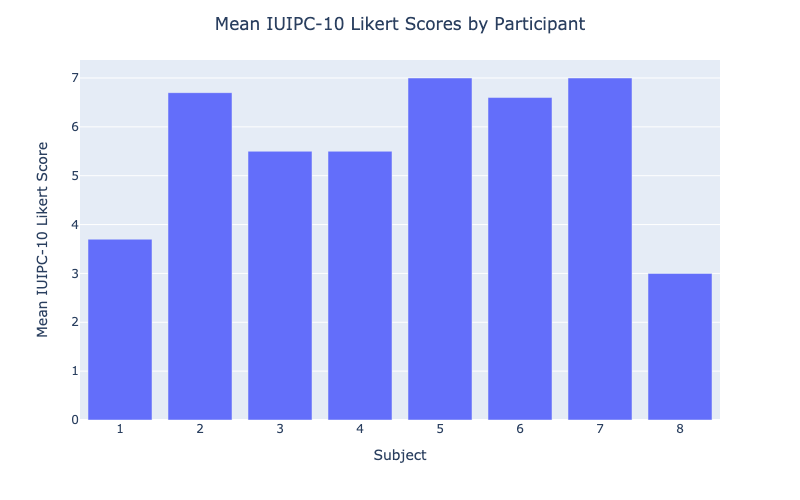

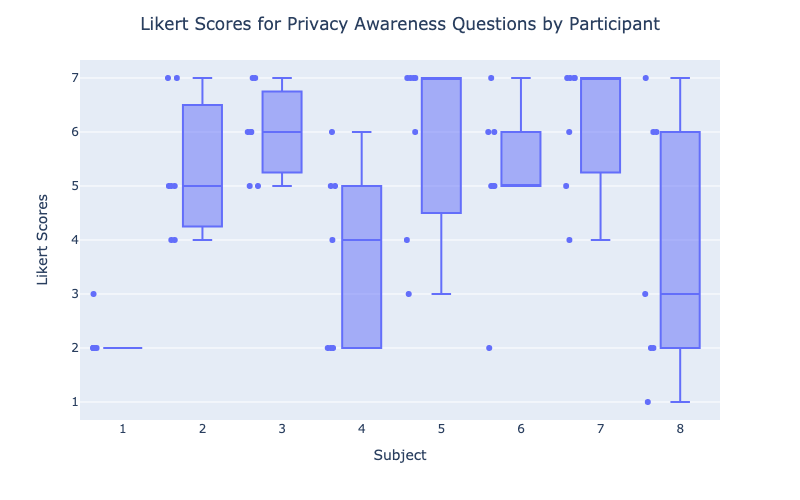

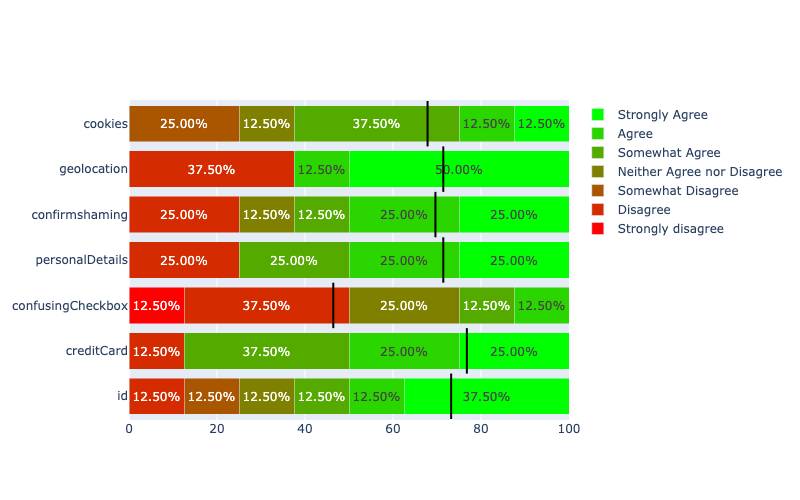

In [269]:
# Bar plot for IUIPC-10 scores
fig = px.bar(meta_df, x=meta_df.index, y='iuipc')
fig.update_layout(
    title='Mean IUIPC-10 Likert Scores by Participant', 
                  title_x=0.5, xaxis_title="Subject", yaxis_title="Mean IUIPC-10 Likert Score", width=800)
fig.show(renderer='png')

# Boxplot for Privacy Dark Patterns Questions likert scores
fig = px.box(df, x='subject', y='likert', points='all')
fig.update_layout(title='Likert Scores for Privacy Awareness Questions by Participant', title_x=0.5, xaxis_title="Subject", yaxis_title="Likert Scores", width=800)
fig.show(renderer='png')

# Bar charts for distribution of responses to dark pattern questions
labels = ["Strongly disagree", "Disagree", "Somewhat Disagree", "Neither Agree nor Disagree", "Somewhat Agree", "Agree", "Strongly Agree"]
colors = n_colors('rgb(255,0,0)', 'rgb(0,255,0)', 7, colortype='rgb')
questions = df.index.unique()
responses = [df[df.index == question]['likert'].tolist() for question in questions]
percentages = [[responses[i].count(j + 1) / len(responses[i]) * 100 for j in range(7)] for i in range(len(responses))]
fig = go.Figure()
for i, label in enumerate(labels):
    fig.add_trace(go.Bar(
        y=questions,
        x=[percentages[j][i] for j in range(len(questions))],
        name=label,
        orientation='h',
        marker=dict(
            color=colors[i],
        ), text=[f"{percentages[j][i]:.2f}%" for j in range(len(questions))],  # Add percentages as text
        textposition='inside',
        insidetextanchor='middle'
    ))
    
for i, q in enumerate(questions):
    mean = np.mean(responses[i]) / 7 * 100
    fig.add_shape(type="line",
                  x0=mean, y0=i-.5, x1=mean, y1=i+.5,
                  line=dict(color="black", width=2),
                  layer="above")

fig.update_layout(barmode='stack', yaxis=dict(autorange="reversed"), width=800, xaxis_range=[0,100])
fig.show(renderer='png')

#### Plot signals for each event averaged across participants

Event: cookies
Mean phasic EDA: 0.023712016591226952
Max. tonic EDA: 15.955187910064769

Event: geolocation
Mean phasic EDA: -0.010858643844542264
Max. tonic EDA: 14.737062416764008

Event: confirmshaming
Mean phasic EDA: -0.01024132863679953
Max. tonic EDA: 13.314527539100498

Event: personalDetails
Mean phasic EDA: 0.006083320342666235
Max. tonic EDA: 13.236976493024558
Event: confusingCheckbox
Mean phasic EDA: -0.007480998148778086
Max. tonic EDA: 12.418858234200236

Event: creditCard
Mean phasic EDA: -0.08359104843191675
Max. tonic EDA: 16.693921425261145

Event: id
Mean phasic EDA: -0.013257814295328813
Max. tonic EDA: 13.027208017017816


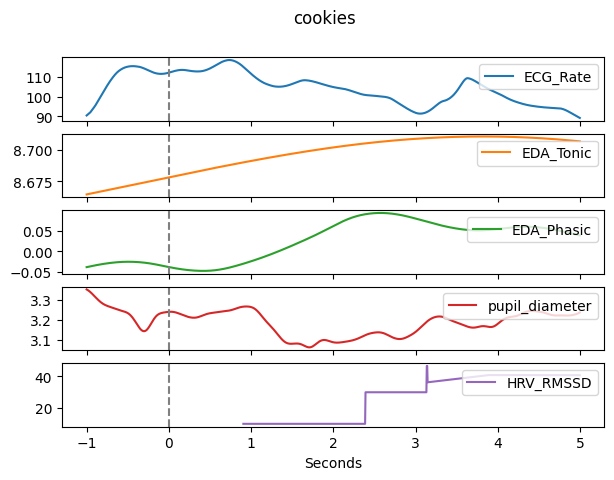

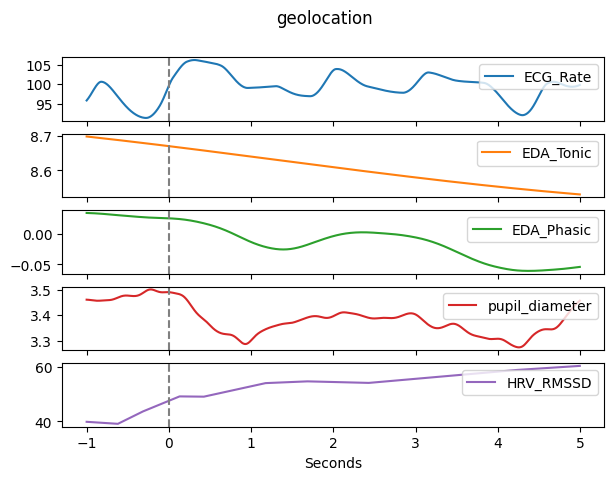

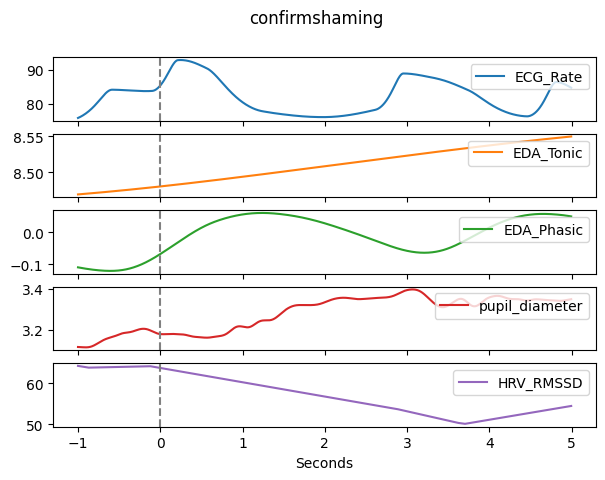

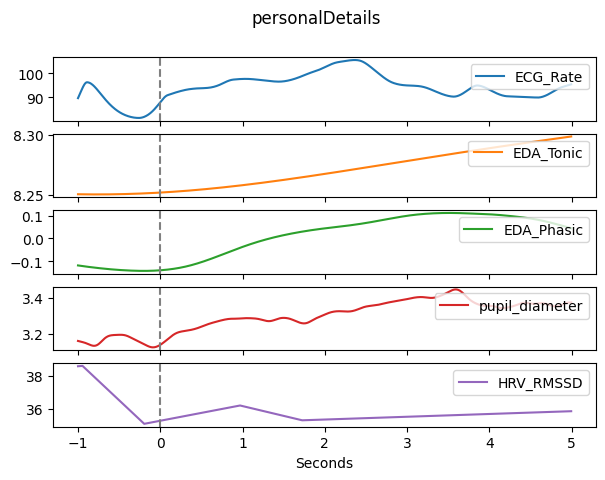

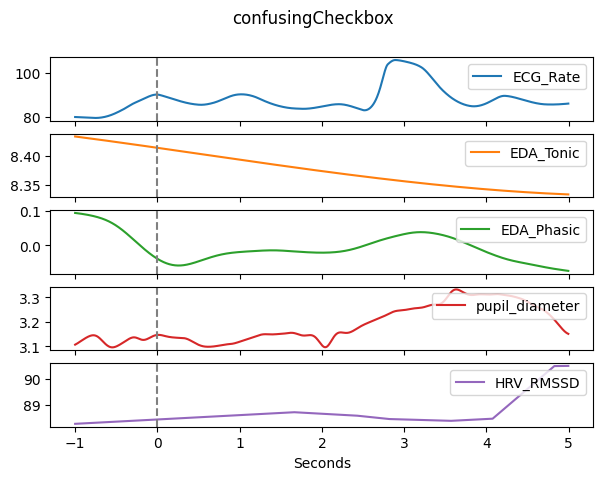

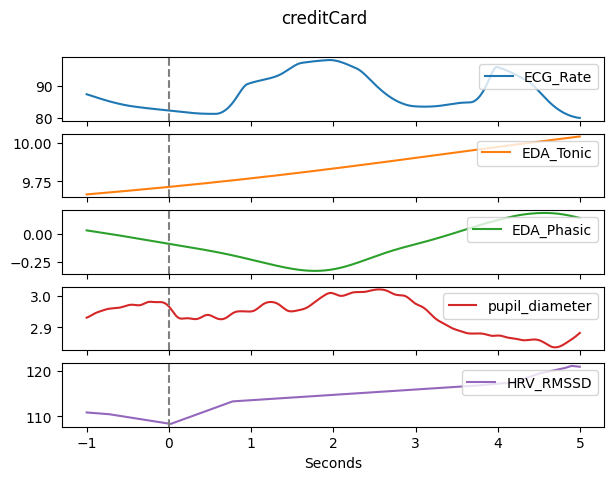

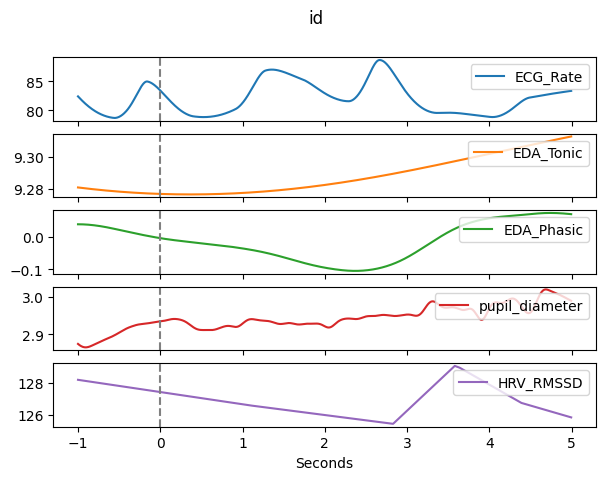

In [270]:
# Plot signals for each event averaged across participants using epoch_signals.csv
columns_to_plot = ['ECG_Rate', 'EDA_Tonic', 'EDA_Phasic', 'pupil_diameter', 'HRV_RMSSD']
for i, event in enumerate(epoch_signal_df.Label.unique()):
    # PRint some features
    print(f"Event: {event}")
    print(f"Mean phasic EDA: {df[df.index == event]['EDA_Phasic_Mean'].mean()}")
    print(f"Max. tonic EDA: {df[df.index == event]['EDA_Tonic_Max'].max()}")
    print()
    
    event_df = epoch_signal_df[epoch_signal_df.Condition == event][["subject", *columns_to_plot]]
    grouped_by_subject = event_df.groupby([event_df.subject])
    event_dfs_per_subject = []
    for subject, _ in grouped_by_subject:
        event_dfs_per_subject.append(grouped_by_subject.get_group(subject).reset_index(drop=True))
            
    averaged_epoch = pd.concat(event_dfs_per_subject).groupby(level=0).mean()
    averaged_epoch.index = [samples_to_seconds(i, info["sampling_rate"]) - 1 for i in averaged_epoch.index]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plot_epoch(averaged_epoch, subplots=True, columns_to_plot=columns_to_plot)
        fig = plt.gcf()
        fig.suptitle(
            # f"Averaged Processed Signals for All Participants from -1 to 5 Seconds for Event:"
                     f"{event}")

        for ax in fig.axes:
            ax.axvline(x=0, color='grey', linestyle='--')

        fig.axes[-1].set_xlabel("Seconds")
        fig.set_figwidth(7)
        fig.show()
    
        
        # save the figure for latex
        # fig.tight_layout()
        # fig.subplots_adjust(top=0.93)
        # fig.savefig(f'/Users/nosh/Documents/Studienprojekt/Studienprojekt/img/epochs/{i+1}.png', dpi=500)

#### Group by event and correlate across participants

In [271]:
columns_to_drop = ['subject', 'ECG_Rate_Baseline', 'ECG_Rate_SD', 'HRV_SDANN1', 'HRV_SDANN2', 'HRV_SDANN5', 'HRV_SDNNI1', 'HRV_SDNNI2', 'HRV_SDNNI5', *df.columns[df.columns.str.endswith(('Atrial', 'Ventricular'))]]

#### Group by participant and correlate across events

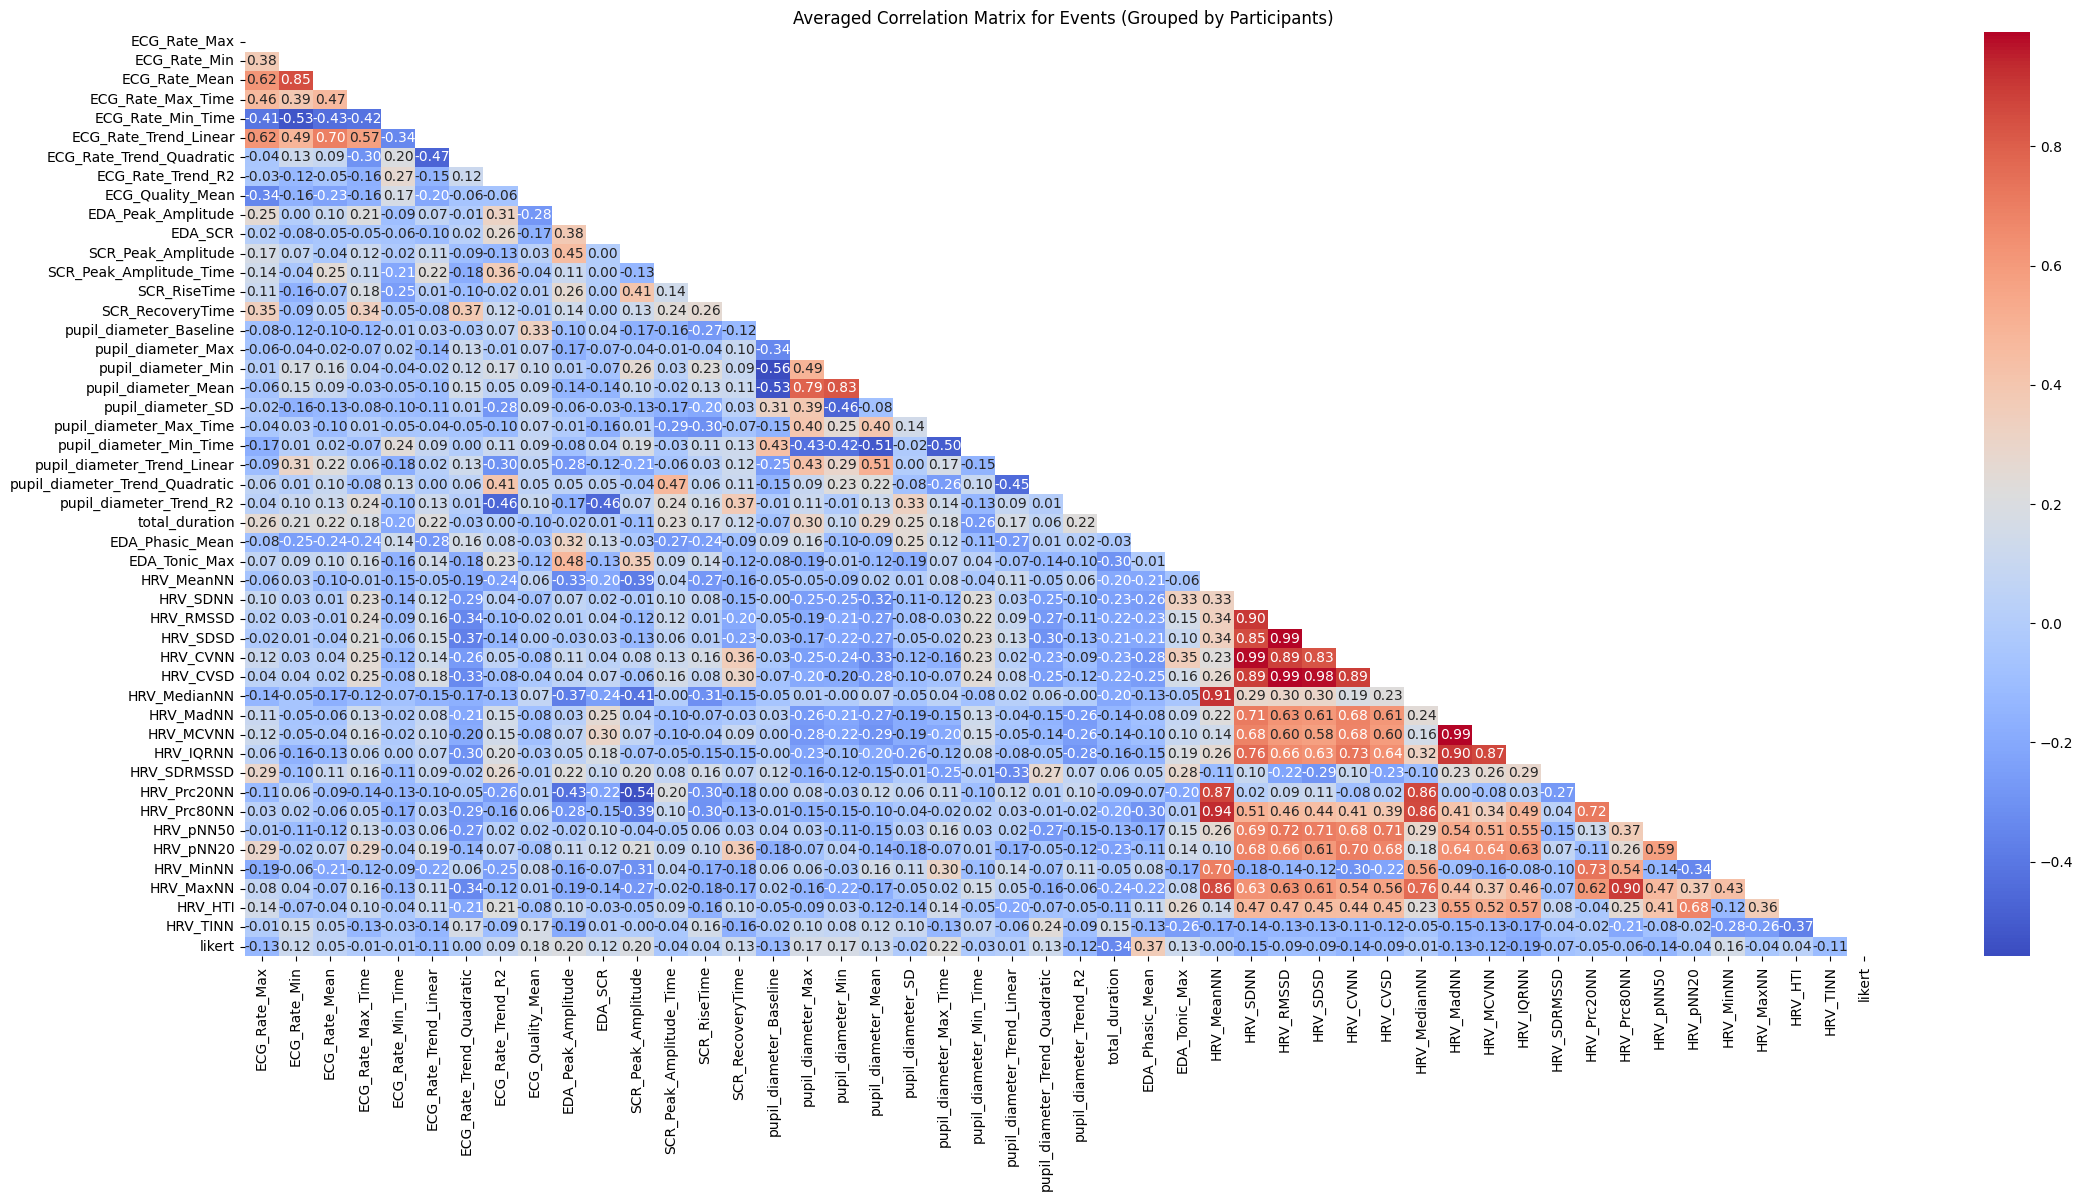

In [272]:
correlation_matrices = []
for subject, data in df.groupby('subject', sort=False):
    data = data.drop(columns=columns_to_drop)
    correlation_matrix = data.corr()
    # plot_correlation_matrix(correlation_matrix, title=f"Averaged Correlation Matrix for Events (Subject {subject})")
    correlation_matrices.append(correlation_matrix)

average_correlation_matrix = pd.concat(correlation_matrices).groupby(level=0, sort=False).sum() / len(correlation_matrices)
plot_correlation_matrix(average_correlation_matrix, title="Averaged Correlation Matrix for Events (Grouped by Participants)")

#### EDA Analysis

In [273]:
# EDA Phasic Mean correlation with IUIPC-10
modified_df = df.groupby('subject')['EDA_Phasic_Mean'].mean().to_frame()
modified_df['iuipc'] = meta_df['iuipc']
print(modified_df)
print(modified_df.corr())

         EDA_Phasic_Mean  iuipc
subject                        
1               0.044836    3.7
2              -0.138742    6.7
3               0.010450    5.5
4               0.003492    5.5
5              -0.054722    7.0
6              -0.017880    6.6
7               0.033428    7.0
8               0.009841    3.0
                 EDA_Phasic_Mean     iuipc
EDA_Phasic_Mean         1.000000 -0.487782
iuipc                  -0.487782  1.000000


In [274]:
# # EDA Analysis per Participant
# # For how many of the participants is the SCR_Peaks_Apmplitude_Mean inside the epochs higher than for the non-epochs?
# 
# # Get SCR_Peaks_Amplitude_Mean during epochs for each participant
# eda_peaks_mean = df.groupby('subject')['SCR_Peak_Amplitude'].mean()
# 
# # Get SCR_Peaks_Amplitude_Mean for the total interval
# eda_peaks_mean_interval = non_epoch_df['SCR_Peaks_Amplitude_Mean']
# 
# print(f"Number of participants with higher mean EDA peak amplitude during epochs than in non-epoch intervals: {sum(eda_peaks_mean > eda_peaks_mean_interval)}")

In [275]:
# # EDA Analysis per Event
# scr_peak_amplitude_dfs = []
# for subject in df['subject'].unique():
#     scr_peak_amplitude  = df[df['subject'] == subject]['SCR_Peak_Amplitude']
#     scr_peak_amplitude = scr_peak_amplitude.to_frame()
#     scr_peak_amplitude['SCR_Peak_Amplitude_Divided'] = scr_peak_amplitude['SCR_Peak_Amplitude'] / non_epoch_df['SCR_Peaks_Amplitude_Mean'][subject]
#     scr_peak_amplitude['likert'] = df[df['subject'] == subject]['likert']
#     scr_peak_amplitude_dfs.append(scr_peak_amplitude)
# 
# scr_peak_amplitude = pd.concat(scr_peak_amplitude_dfs)
# 
# for event in scr_peak_amplitude.index.unique():
#     filtered_by_event = scr_peak_amplitude[scr_peak_amplitude.index == event]
#     print(f"Event: {event}")
#     print(f"{filtered_by_event['SCR_Peak_Amplitude'].count()} participants had a skin conductance response during the {event} epoch.")
#     correlation1 = filtered_by_event['SCR_Peak_Amplitude'].corr(filtered_by_event['likert'])
#     print(f"Correlation between SCR peak amplitude during the epoch and corresponding likert score: {correlation1}")
#     correlation2 = filtered_by_event['SCR_Peak_Amplitude_Divided'].corr(filtered_by_event['likert'])
#     print(f"Correlation between SCR peak amplitude during the epoch / during the non-epoch quotient and corresponding Likert score: {correlation2}")
#     print()

#### ECG Analysis

In [276]:
# # ECG Analysis per Participant
# # For how many of the participants is the mean heart rate inside the epochs higher than for the total interval?
# 
# # Get mean heart rate during epochs for each participant
# modified_df = df.copy()
# modified_df['ECG_Rate_Mean'] += modified_df['ECG_Rate_Baseline']
# mean_heart_rate = modified_df.groupby('subject')['ECG_Rate_Mean'].mean()
# 
# # Get mean heart rate for the total interval
# mean_heart_rate_interval = non_epoch_df['ECG_Rate_Mean']
# 
# print(f"Number of participants with higher mean heart rate during epochs than in non-epoch intervals: {sum(mean_heart_rate > mean_heart_rate_interval)}")
# 
# print(mean_heart_rate)
# print(mean_heart_rate_interval)
# print((mean_heart_rate - mean_heart_rate_interval).mean())

In [277]:
# # ECG Analysis per Event
# mean_heart_rate_dfs = []
# for subject in df['subject'].unique():
#     mean_heart_rate = modified_df[modified_df['subject'] == subject]['ECG_Rate_Baseline']
#     mean_heart_rate = mean_heart_rate.to_frame()
#     mean_heart_rate['ECG_Rate_Baseline'] -= non_epoch_df['ECG_Rate_Mean'][subject]
#     mean_heart_rate['likert'] = df[df['subject'] == subject]['likert']
#     mean_heart_rate_dfs.append(mean_heart_rate)
# 
# mean_heart_rate = pd.concat(mean_heart_rate_dfs) 
# 
# for event in mean_heart_rate.index.unique():
#     filtered_by_event = mean_heart_rate[mean_heart_rate.index == event]
#     print(f"Event: {event}")
#     print(f"{sum(filtered_by_event['ECG_Rate_Baseline'] > 0)} participants had a higher mean heart rate during the {event} epoch.")
#     correlation = filtered_by_event['ECG_Rate_Baseline'].corr(filtered_by_event['likert'])
#     print(f"Correlation between mean heart rate increase during the epoch and corresponding Likert score: {correlation}")
#     print()